In [1]:
import sys
import os
from typing import Optional
from tqdm import tqdm
sys.path.append(os.path.abspath('../'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import os
from IPython.display import display, HTML


from utils.plot_utils import *

pd.set_option('display.max_rows', 500)

## CoT over 10k points

It isimportant to note that for the results are sensitive to whether we filter for NANs, i.e. directly asking early one on the MATH dataset tends to results in NaN values

In [2]:
base_dir = "/n/holylabs/LABS/sitanc_lab/Users/mfli/critical-windows-lm/results/NoiseDenoise"
datasets = [d for d in os.listdir(base_dir) if d.startswith("NoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=") and d.endswith("_nsamples=10000_num_per_noise=1")]

real_dataset_names = [d.split("_dataset=")[1].split("_split=")[0] for d in datasets]
dataset_names = ["MATH","AQUA-RAT","LogiQA","ARC Challenge", "ARC Easy", "MMLU", "TruthfulQA"]
print(real_dataset_names)

print(dataset_names)

['competition_math', 'deepmind-aqua_rat', 'allenai-ai2_arc-ARC-Easy', 'truthfulqa-truthful_qa', 'cais-mmlu', 'lucasmccabe-logiqa', 'allenai-ai2_arc-ARC-Challenge']
['MATH', 'AQUA-RAT', 'LogiQA', 'ARC Challenge', 'ARC Easy', 'MMLU', 'TruthfulQA']


In [3]:
combined_df = pd.DataFrame()

for dataset, dataset_name in tqdm(list(zip(datasets, dataset_names))):
    file_path = os.path.join(base_dir, dataset, "eval_noisedenoise.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['dataset_source'] = dataset_name
        combined_df = pd.concat([combined_df, df], ignore_index=True)

print("Before dropping NA for orig_answer")
print(combined_df.shape)

combined_df = combined_df[~combined_df.orig_ans_format.isna()]
print("After dropping NA for orig_answer")
print(combined_df.shape)
print(len(combined_df.no_deno_string_ans.unique()))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:21<00:00,  3.03s/it]


Before dropping NA for orig_answer
(234378, 20)
After dropping NA for orig_answer
(233826, 20)
233456


In [4]:
combined_df[combined_df.no_deno_string_ans.duplicated(keep=False)].head(5)

problem formatted_answer  stop_frac  \
284  How many perfect squares are factors of 180?                4        0.3   
287  How many perfect squares are factors of 180?                4        0.9   
352      What is the largest prime factor of 999?               37        0.7   
353      What is the largest prime factor of 999?               37        0.9   
418                      What is $\frac56$ of 30?               25        0.7   

     no              orig_ans_string orig_ans_format  \
284   0   The answer is $\boxed{4}$.               4   
287   0   The answer is $\boxed{4}$.               4   
352   0          The answer is $37$.              37   
353   0          The answer is $37$.              37   
418   0  The answer is $\boxed{25}$.              25   

                                      stump_ans_string stump_ans_format  \
284  To find the perfect squares that are factors o...              NaN   
287                         The answer is $\boxed{4}$.                4   
352                                The answer is $37$.               37   
353                                The answer is $37$.               37   
418                        The answer is $\boxed{25}$.               25   

    no_deno_ans_format           no_deno_ans_string  is_consistent  is_right  \
284                  4   The answer is $\boxed{4}$.           True      True   
287                  4   The answer is $\boxed{4}$.           True      True   
352                 37          The answer is $37$.           True      True   
353                 37          The answer is $37$.           True      True   
418                 25  The answer is $\boxed{25}$.           True      True   

     orig_is_right  stump_is_right  is_stump  stump_is_consistent  \
284           True           False     False                False   
287           True            True      True                 True   
352           True            True      True                 True   
353           True            True      True                 True   
418           True            True      True                 True   

                                      stump_string_ans  \
284  <|begin_of_text|><|start_header_id|>system<|en...   
287  <|begin_of_text|><|start_header_id|>system<|en...   
352  <|begin_of_text|><|start_header_id|>system<|en...   
353  <|begin_of_text|><|start_header_id|>system<|en...   
418  <|begin_of_text|><|start_header_id|>system<|en...   

                                    no_deno_string_ans  \
284  <|begin_of_text|><|start_header_id|>system<|en...   
287  <|begin_of_text|><|start_header_id|>system<|en...   
352  <|begin_of_text|><|start_header_id|>system<|en...   
353  <|begin_of_text|><|start_header_id|>system<|en...   
418  <|begin_of_text|><|start_header_id|>system<|en...   

                                       orig_string_ans dataset_source  
284  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
287  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
352  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
353  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
418  <|begin_of_text|><|start_header_id|>system<|en...           MATH

In [5]:
display(combined_df.head())

problem formatted_answer  stop_frac  no  \
0  Evaluate $\log_432$.      \frac{5}{2}       0.05   0   
1  Evaluate $\log_432$.      \frac{5}{2}       0.10   0   
2  Evaluate $\log_432$.      \frac{5}{2}       0.30   0   
3  Evaluate $\log_432$.      \frac{5}{2}       0.50   0   
4  Evaluate $\log_432$.      \frac{5}{2}       0.70   0   

                        orig_ans_string orig_ans_format  \
0  The answer is $\boxed{\frac{5}{2}}$.     \frac{5}{2}   
1  The answer is $\boxed{\frac{5}{2}}$.     \frac{5}{2}   
2  The answer is $\boxed{\frac{5}{2}}$.     \frac{5}{2}   
3  The answer is $\boxed{\frac{5}{2}}$.     \frac{5}{2}   
4  The answer is $\boxed{\frac{5}{2}}$.     \frac{5}{2}   

                                    stump_ans_string stump_ans_format  \
0  To evaluate $\log_432$, we can use the change ...              NaN   
1  To evaluate $\log_432$, we can use the change ...              NaN   
2  To evaluate $\log_432$, we can use the change ...              NaN   
3  To evaluate $\log_432$, we can use the change ...              NaN   
4               The answer is $\boxed{\frac{5}{2}}$.      \frac{5}{2}   

  no_deno_ans_format                    no_deno_ans_string  is_consistent  \
0        \frac{5}{2}  The answer is $\boxed{\frac{5}{2}}$.           True   
1        \frac{5}{2}  The answer is $\boxed{\frac{5}{2}}$.           True   
2        \frac{5}{2}  The answer is $\boxed{\frac{5}{2}}$.           True   
3        \frac{5}{2}  The answer is $\boxed{\frac{5}{2}}$.           True   
4        \frac{5}{2}  The answer is $\boxed{\frac{5}{2}}$.           True   

   is_right  orig_is_right  stump_is_right  is_stump  stump_is_consistent  \
0      True           True           False     False                False   
1      True           True           False     False                False   
2      True           True           False     False                False   
3      True           True           False     False                False   
4      True           True            True      True                 True   

                                    stump_string_ans  \
0  <|begin_of_text|><|start_header_id|>system<|en...   
1  <|begin_of_text|><|start_header_id|>system<|en...   
2  <|begin_of_text|><|start_header_id|>system<|en...   
3  <|begin_of_text|><|start_header_id|>system<|en...   
4  <|begin_of_text|><|start_header_id|>system<|en...   

                                  no_deno_string_ans  \
0  <|begin_of_text|><|start_header_id|>system<|en...   
1  <|begin_of_text|><|start_header_id|>system<|en...   
2  <|begin_of_text|><|start_header_id|>system<|en...   
3  <|begin_of_text|><|start_header_id|>system<|en...   
4  <|begin_of_text|><|start_header_id|>system<|en...   

                                     orig_string_ans dataset_source  
0  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
1  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
2  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
3  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
4  <|begin_of_text|><|start_header_id|>system<|en...           MATH

0.05       0.1       0.3       0.5       0.7       0.9  \
dataset_source                                                               
AQUA-RAT        0.701795  0.702798  0.693974  0.694074  0.702597  0.712123   
ARC Challenge   0.679315  0.675643  0.685435  0.687882  0.676867  0.678091   
ARC Easy        0.827248  0.826248  0.821446  0.821046  0.824547  0.822547   
LogiQA          0.941804  0.944025  0.938250  0.940027  0.940915  0.946690   
MATH            0.690012  0.687458  0.683291  0.689206  0.692297  0.697406   
MMLU            0.514441  0.520000  0.508610  0.515254  0.515390  0.520814   
TruthfulQA      0.879357  0.881144  0.879357  0.876676  0.884718  0.879357   

                orig_is_right  
dataset_source                 
AQUA-RAT             0.714128  
ARC Challenge        0.668299  
ARC Easy             0.825591  
LogiQA               0.946246  
MATH                 0.697674  
MMLU                 0.517387  
TruthfulQA           0.875671

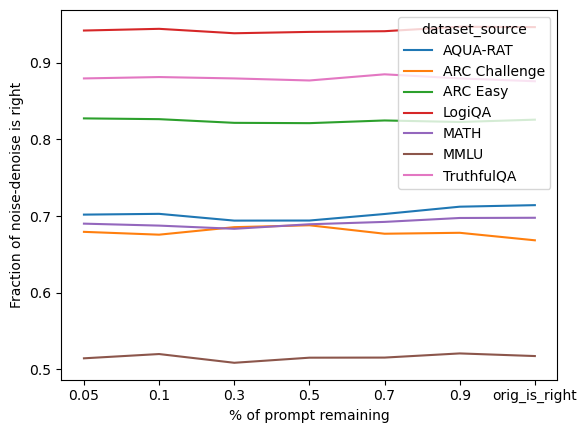

In [6]:
display(display_then_plot(combined_df, "is_right","orig_is_right","Fraction of noise-denoise is right"))

0.05       0.1       0.3       0.5       0.7       0.9  \
dataset_source                                                               
AQUA-RAT        0.061265  0.115412  0.237140  0.333099  0.406096  0.466159   
ARC Challenge   0.512852  0.580171  0.632803  0.640147  0.652387  0.662179   
ARC Easy        0.763929  0.796339  0.821646  0.824247  0.829149  0.828949   
LogiQA          0.346068  0.756553  0.941804  0.941359  0.939138  0.946246   
MATH            0.173545  0.224896  0.296142  0.336470  0.399247  0.586100   
MMLU            0.453153  0.507254  0.515661  0.518102  0.518102  0.520000   
TruthfulQA      0.345845  0.699732  0.850760  0.853441  0.860590  0.873995   

                orig_is_right  
dataset_source                 
AQUA-RAT             0.714128  
ARC Challenge        0.668299  
ARC Easy             0.825591  
LogiQA               0.946246  
MATH                 0.697674  
MMLU                 0.517387  
TruthfulQA           0.875671

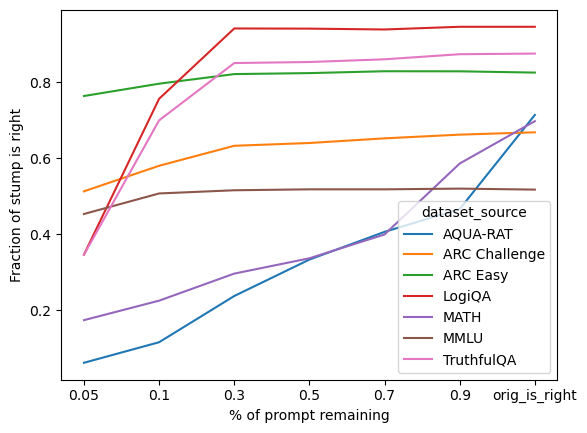

In [7]:
display(display_then_plot(combined_df, "stump_is_right","orig_is_right","Fraction of stump is right"))

stop_frac           0.05      0.10      0.30      0.50      0.70      0.90
dataset_source                                                            
AQUA-RAT        0.714329  0.721247  0.756843  0.790635  0.823122  0.873458
ARC Challenge   0.762546  0.780906  0.807834  0.853121  0.877601  0.954712
ARC Easy        0.846654  0.854356  0.874362  0.899470  0.932680  0.967290
LogiQA          0.939582  0.944913  0.952021  0.973789  0.977788  0.995113
MATH            0.610700  0.619035  0.648878  0.696330  0.755209  0.851593
MMLU            0.656271  0.647186  0.693831  0.781831  0.858712  0.934102
TruthfulQA      0.874888  0.889187  0.907060  0.934763  0.949955  0.974978

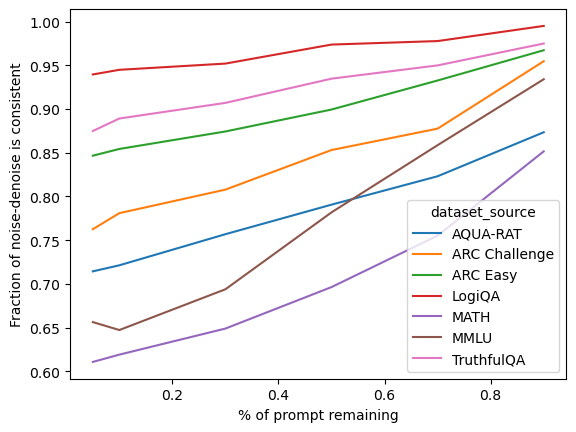

In [8]:
display(display_then_plot(combined_df, "is_consistent",None,"Fraction of noise-denoise is consistent"))

stop_frac           0.05      0.10      0.30      0.50      0.70      0.90
dataset_source                                                            
AQUA-RAT        0.084829  0.152612  0.305625  0.414319  0.505264  0.594605
ARC Challenge   0.586291  0.698898  0.773562  0.809058  0.864137  0.931457
ARC Easy        0.787336  0.823047  0.859258  0.879264  0.905472  0.953186
LogiQA          0.348290  0.762772  0.946246  0.960018  0.970235  0.987117
MATH            0.145181  0.190348  0.263342  0.310794  0.395080  0.637855
MMLU            0.565966  0.634983  0.660610  0.725017  0.804068  0.895322
TruthfulQA      0.347632  0.716711  0.873101  0.892761  0.925827  0.964254

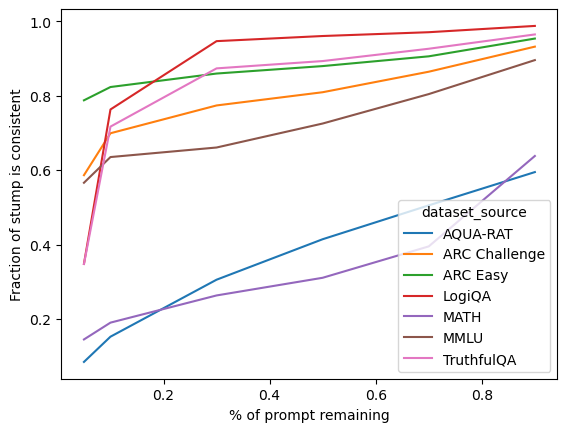

In [9]:
display(display_then_plot(combined_df, "stump_is_consistent",None,"Fraction of stump is consistent"))

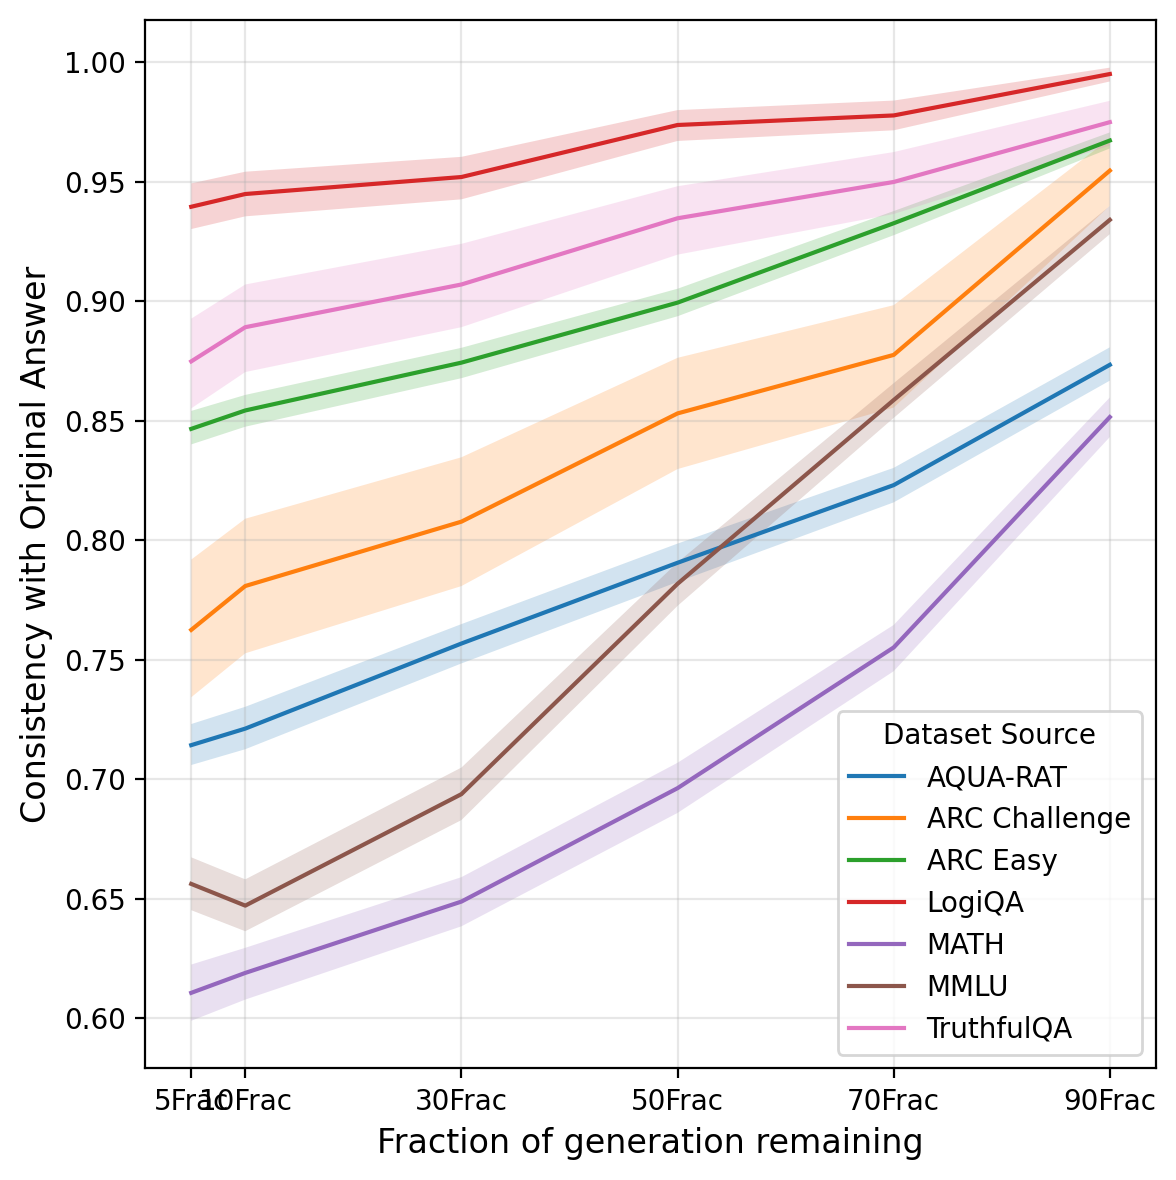

In [10]:
# Preparing data for plotting
plot_data = []
for (dataset_source, stop_frac), group in combined_df.groupby(["dataset_source", "stop_frac"]):
    mean, lower, upper = compute_ci(group["is_consistent"])
    plot_data.append({
        "dataset_source": dataset_source,
        "stop_frac": stop_frac,
        "mean": mean,
        "ci_lower": lower,
        "ci_upper": upper
    })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Create the plot
plt.figure(figsize=(6, 6),dpi=200)
for dataset in plot_df["dataset_source"].unique():
    data = plot_df[plot_df["dataset_source"] == dataset]
    plt.plot(data["stop_frac"], data["mean"], label=dataset)
    plt.fill_between(data["stop_frac"], data["ci_lower"], data["ci_upper"], alpha=0.2)

# Customize plot
plt.xlabel("Fraction of generation remaining", fontsize=12)
plt.ylabel("Consistency with Original Answer", fontsize=12)
plt.xticks(plot_df["stop_frac"].unique(), labels=[f"{int(x*100)}Frac" for x in plot_df["stop_frac"].unique()])
plt.legend(title="Dataset Source")
plt.grid(alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

Text(0.5, 1.0, 'Other Datasets')

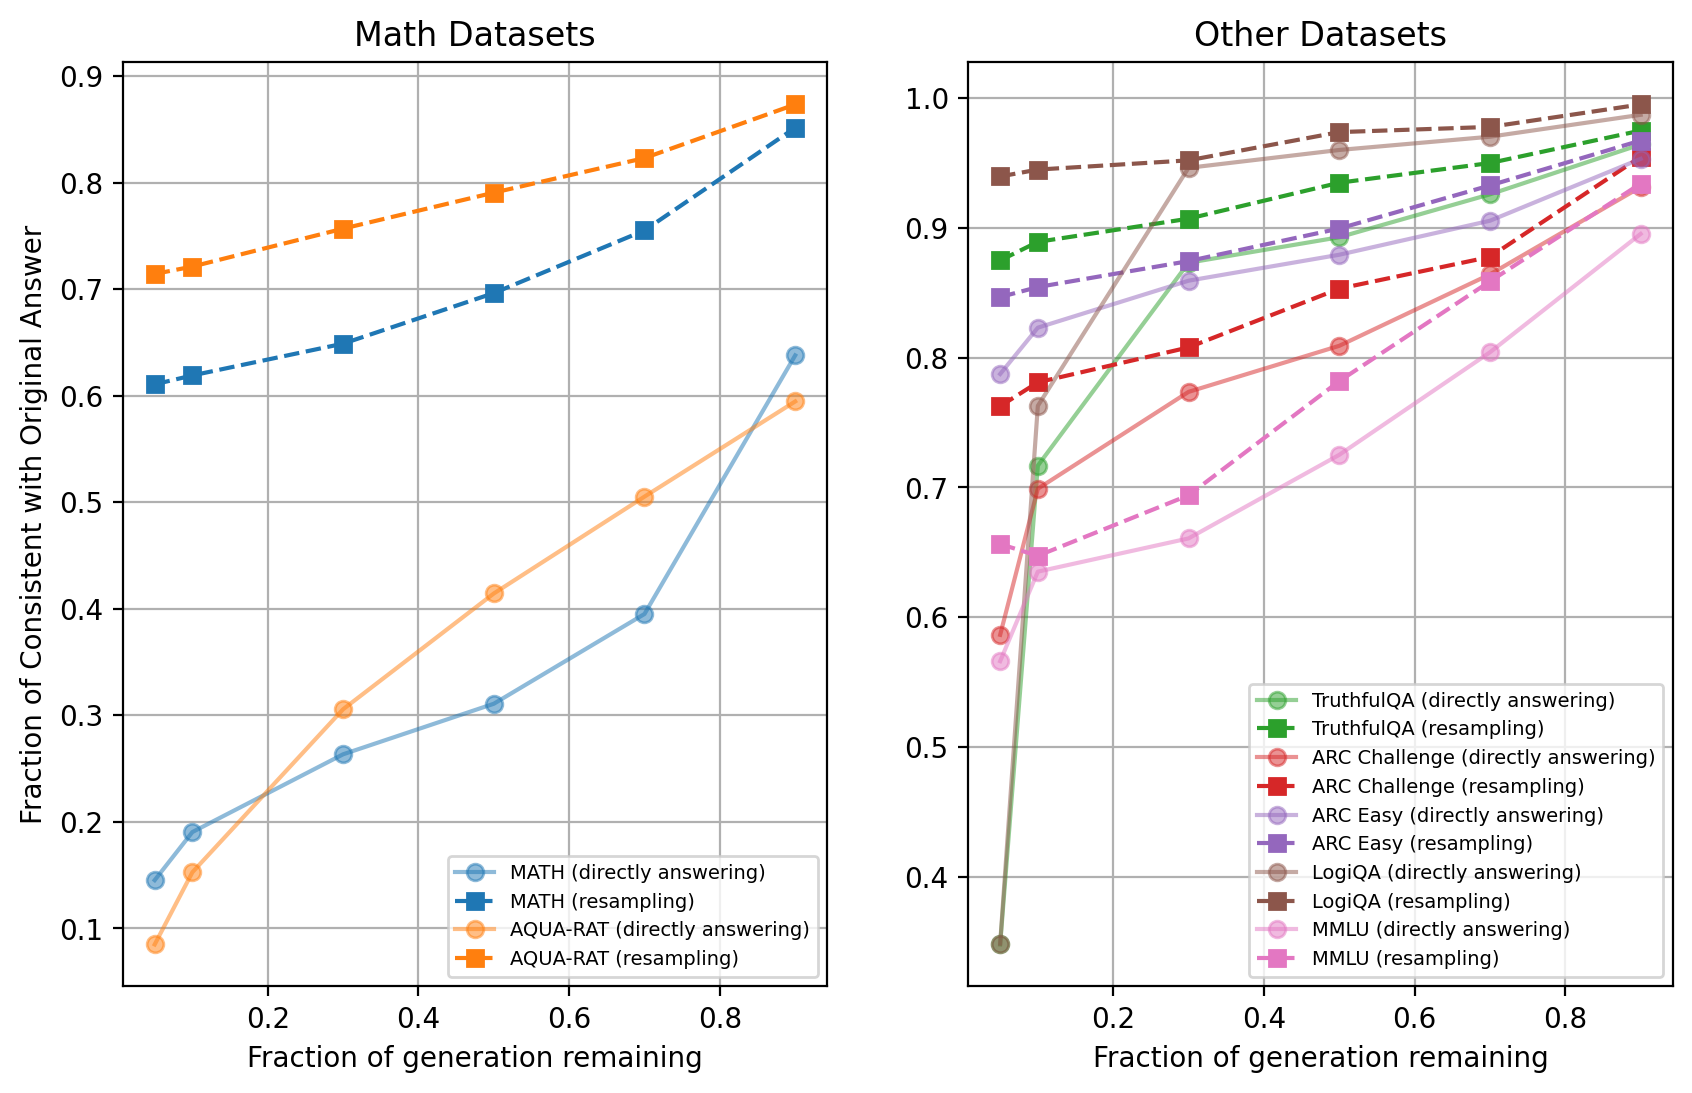

In [11]:
# Compute the means grouped by dataset_source and stop_frac
stump_means = (combined_df
               .groupby(["dataset_source", "stop_frac"])["stump_is_consistent"]
               .mean()
               .reset_index())

not_stump_means = (combined_df
                   .groupby(["dataset_source", "stop_frac"])["is_consistent"]
                   .mean()
                   .reset_index())

# Merge the two datasets for easier plotting of arrows
merged_means = pd.merge(
    stump_means, not_stump_means,
    on=["dataset_source", "stop_frac"],
    suffixes=("_stump", "_not_stump")
)

# Set up the plot
fig, axs = plt.subplots(1,2,figsize=(10, 6), dpi=200)

# Assign colors for each dataset_source
colors = plt.cm.tab10(range(len(merged_means["dataset_source"].unique())))

# Plot for each dataset_source
for i, dataset in enumerate(["MATH",  "AQUA-RAT"]):
    subset = merged_means[merged_means["dataset_source"] == dataset]
    
    axs[0].plot(subset["stop_frac"], subset["stump_is_consistent"],alpha=0.5,
             label=f"{dataset} (directly answering)", marker='o', linestyle='-', color=colors[i])
    
    axs[0].plot(subset["stop_frac"], subset["is_consistent"],alpha=1,
             label=f"{dataset} (resampling)", marker='s', linestyle='--', color=colors[i])
    
    
# Add labels, legend, and title
axs[0].set_xlabel("Fraction of generation remaining")
axs[0].set_ylabel("Fraction of Consistent with Original Answer")
axs[0].set_title("Math Datasets")
axs[0].legend(fontsize=7)
axs[0].grid(True)

# Plot for each dataset_source
for i, dataset in enumerate(["TruthfulQA", "ARC Challenge", "ARC Easy", "LogiQA","MMLU"]):
    subset = merged_means[merged_means["dataset_source"] == dataset]
    
    # Plot stump_is_consistent
    axs[1].plot(subset["stop_frac"], subset["stump_is_consistent"],alpha=0.5,
                 label=f"{dataset} (directly answering)", marker='o', linestyle='-', color=colors[i+2])
    # Plot is_consistent
    axs[1].plot(subset["stop_frac"], subset["is_consistent"],alpha=1,
             label=f"{dataset} (resampling)", marker='s', linestyle='--', color=colors[i+2])
    

# Add labels, legend, and title
axs[1].set_xlabel("Fraction of generation remaining")
axs[1].grid(True)
axs[1].legend(fontsize=7)
axs[1].set_title("Other Datasets")


## Conditioning on correctness 

Doesn't seem to be that meaningful because ``is_right`` only affects ``is_consistent`` through ``orig_is_right``?

In [12]:
correlations = pd.DataFrame(combined_df
                .groupby(["dataset_source", "stop_frac"])
                .apply(lambda x: x["is_right"].corr(x["is_consistent"]))
)

# Display the results
display(correlations)

/tmp/ipykernel_258926/4143215539.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x["is_right"].corr(x["is_consistent"]))


0
dataset_source stop_frac          
AQUA-RAT       0.05       0.503848
               0.10       0.506324
               0.30       0.482287
               0.50       0.464361
               0.70       0.418159
               0.90       0.362171
ARC Challenge  0.05       0.349969
               0.10       0.378887
               0.30       0.331923
               0.50       0.272719
               0.70       0.292959
               0.90       0.139716
ARC Easy       0.05       0.444417
               0.10       0.436341
               0.30       0.419032
               0.50       0.378505
               0.70       0.302187
               0.90       0.229583
LogiQA         0.05       0.590037
               0.10       0.542621
               0.30       0.546908
               0.50       0.427012
               0.70       0.409696
               0.90       0.125160
MATH           0.05       0.719076
               0.10       0.722745
               0.30       0.729358
               0.50       0.684639
               0.70       0.620273
               0.90       0.487241
MMLU           0.05       0.257679
               0.10       0.265267
               0.30       0.238002
               0.50       0.193822
               0.70       0.151140
               0.90       0.085457
TruthfulQA     0.05       0.473611
               0.10       0.433365
               0.30       0.401167
               0.50       0.352162
               0.70       0.250828
               0.90       0.204152

## Per example COT

In [13]:
base_dir = "/n/holylabs/LABS/sitanc_lab/Users/mfli/critical-windows-lm/results/NoiseDenoise"
datasets = [d for d in os.listdir(base_dir) if d.startswith("NoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=") and d.endswith("_nsamples=400_num_per_noise=25")]

real_dataset_names = [d.split("_dataset=")[1].split("_split=")[0] for d in datasets]
dataset_names = ["MATH","AQUA-RAT","LogiQA","ARC Challenge", "ARC Easy", "MMLU", "TruthfulQA"]
print(real_dataset_names)

print(dataset_names)

['competition_math', 'deepmind-aqua_rat', 'lucasmccabe-logiqa', 'allenai-ai2_arc-ARC-Challenge', 'allenai-ai2_arc-ARC-Easy', 'cais-mmlu', 'truthfulqa-truthful_qa']
['MATH', 'AQUA-RAT', 'LogiQA', 'ARC Challenge', 'ARC Easy', 'MMLU', 'TruthfulQA']


In [14]:
combined_df = pd.DataFrame()

for dataset, dataset_name in tqdm(list(zip(datasets, dataset_names))):
    file_path = os.path.join(base_dir, dataset, "eval_noisedenoise.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['dataset_source'] = dataset_name
        combined_df = pd.concat([combined_df, df], ignore_index=True)

print("Before dropping NA for orig_answer")
print(combined_df.shape)

combined_df = combined_df[~combined_df.orig_ans_format.isna()]
print("After dropping NA for orig_answer")
print(combined_df.shape)

print(len(combined_df.no_deno_string_ans.unique()))
display(combined_df[["dataset_source","no_deno_string_ans"]].drop_duplicates().groupby("dataset_source")["no_deno_string_ans"].count())
display(combined_df[["stop_frac","no_deno_string_ans"]].drop_duplicates().groupby("stop_frac")["no_deno_string_ans"].count())
display(combined_df.head())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:24<00:00,  3.45s/it]


Before dropping NA for orig_answer
(420000, 20)
After dropping NA for orig_answer
(419700, 20)
121330


dataset_source
AQUA-RAT         30409
ARC Challenge    15982
ARC Easy         15513
LogiQA            9337
MATH             29725
MMLU              7653
TruthfulQA       12711
Name: no_deno_string_ans, dtype: int64

stop_frac
0.05    24689
0.10    24169
0.30    23607
0.50    22034
0.70    17370
0.90     9629
Name: no_deno_string_ans, dtype: int64

problem formatted_answer  stop_frac  no  \
0  Find $\sec 135^\circ.$        -\sqrt{2}       0.05   0   
1  Find $\sec 135^\circ.$        -\sqrt{2}       0.05   1   
2  Find $\sec 135^\circ.$        -\sqrt{2}       0.05   2   
3  Find $\sec 135^\circ.$        -\sqrt{2}       0.05   3   
4  Find $\sec 135^\circ.$        -\sqrt{2}       0.05   4   

              orig_ans_string orig_ans_format  \
0  The answer is $-\sqrt{2}$.       -\sqrt{2}   
1  The answer is $-\sqrt{2}$.       -\sqrt{2}   
2  The answer is $-\sqrt{2}$.       -\sqrt{2}   
3  The answer is $-\sqrt{2}$.       -\sqrt{2}   
4  The answer is $-\sqrt{2}$.       -\sqrt{2}   

                                    stump_ans_string stump_ans_format  \
0  To find $\sec 135^\circ$, we can use the defin...              NaN   
1  To find $\sec 135^\circ$, we can use the defin...              NaN   
2  To find $\sec 135^\circ$, we can use the defin...              NaN   
3  To find $\sec 135^\circ$, we can use the defin...              NaN   
4  To find $\sec 135^\circ$, we can use the defin...              NaN   

  no_deno_ans_format                  no_deno_ans_string  is_consistent  \
0          -\sqrt{2}  The answer is $\boxed{-\sqrt{2}}$.           True   
1          -\sqrt{2}          The answer is $-\sqrt{2}$.           True   
2          -\sqrt{2}          The answer is $-\sqrt{2}$.           True   
3          -\sqrt{2}          The answer is $-\sqrt{2}$.           True   
4          -\sqrt{2}          The answer is $-\sqrt{2}$.           True   

   is_right  orig_is_right  stump_is_right  is_stump  stump_is_consistent  \
0      True           True           False     False                False   
1      True           True           False     False                False   
2      True           True           False     False                False   
3      True           True           False     False                False   
4      True           True           False     False                False   

                                    stump_string_ans  \
0  <|begin_of_text|><|start_header_id|>system<|en...   
1  <|begin_of_text|><|start_header_id|>system<|en...   
2  <|begin_of_text|><|start_header_id|>system<|en...   
3  <|begin_of_text|><|start_header_id|>system<|en...   
4  <|begin_of_text|><|start_header_id|>system<|en...   

                                  no_deno_string_ans  \
0  <|begin_of_text|><|start_header_id|>system<|en...   
1  <|begin_of_text|><|start_header_id|>system<|en...   
2  <|begin_of_text|><|start_header_id|>system<|en...   
3  <|begin_of_text|><|start_header_id|>system<|en...   
4  <|begin_of_text|><|start_header_id|>system<|en...   

                                     orig_string_ans dataset_source  
0  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
1  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
2  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
3  <|begin_of_text|><|start_header_id|>system<|en...           MATH  
4  <|begin_of_text|><|start_header_id|>system<|en...           MATH

stop_frac           0.05      0.10      0.30      0.50      0.70      0.90
dataset_source                                                            
AQUA-RAT        0.687719  0.703358  0.684712  0.678596  0.700952  0.701654
ARC Challenge   0.897600  0.899800  0.894700  0.885200  0.862300  0.892000
ARC Easy        0.946600  0.948400  0.944100  0.944200  0.950900  0.945700
LogiQA          0.525400  0.508100  0.518400  0.506800  0.491000  0.500300
MATH            0.713684  0.705263  0.715890  0.698346  0.724211  0.726717
MMLU            0.825900  0.816900  0.841300  0.832300  0.827000  0.820000
TruthfulQA      0.665200  0.690600  0.672400  0.705600  0.698200  0.705500

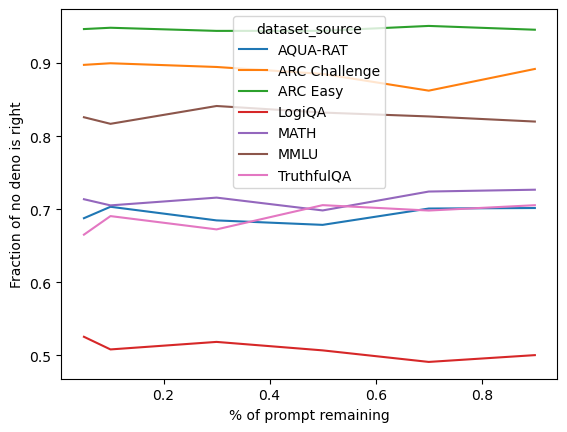

In [15]:
display(display_then_plot(combined_df, "is_right",None,"Fraction of no deno is right"))

stop_frac           0.05      0.10      0.30      0.50      0.70      0.90
dataset_source                                                            
AQUA-RAT        0.060150  0.127820  0.255639  0.343358  0.423559  0.463659
ARC Challenge   0.362500  0.677500  0.862500  0.865000  0.860000  0.902500
ARC Easy        0.385000  0.785000  0.935000  0.940000  0.937500  0.937500
LogiQA          0.490000  0.525000  0.545000  0.537500  0.490000  0.480000
MATH            0.180451  0.215539  0.265664  0.300752  0.363409  0.571429
MMLU            0.757500  0.782500  0.812500  0.825000  0.820000  0.820000
TruthfulQA      0.540000  0.610000  0.640000  0.642500  0.692500  0.690000

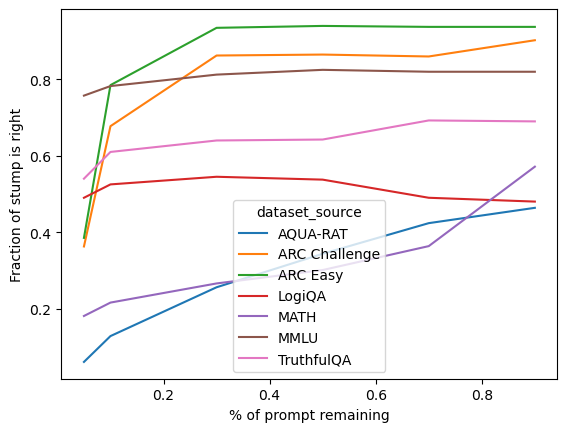

In [16]:
display(display_then_plot(combined_df, "stump_is_right",None,"Fraction of stump is right"))

stop_frac           0.05      0.10      0.30      0.50      0.70      0.90
dataset_source                                                            
AQUA-RAT        0.713985  0.727018  0.756792  0.782055  0.825965  0.878296
ARC Challenge   0.886500  0.887900  0.911900  0.922000  0.933800  0.975100
ARC Easy        0.945700  0.952300  0.940200  0.961400  0.986200  0.985700
LogiQA          0.637500  0.625000  0.713500  0.805100  0.886700  0.947600
MATH            0.652130  0.657143  0.694336  0.712982  0.780451  0.877995
MMLU            0.873200  0.894900  0.878900  0.916500  0.962400  0.985300
TruthfulQA      0.763900  0.762700  0.794600  0.859300  0.885000  0.942200

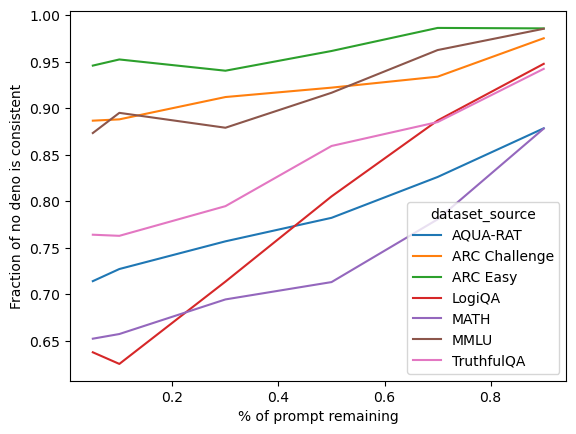

In [17]:
## is_consistent over stop_frac

display(display_then_plot(combined_df, "is_consistent",None,"Fraction of no deno is consistent"))


In [18]:
orig_is_right_df = combined_df.query("orig_is_right")
percent_consistent = combined_df.groupby(["dataset_source","problem","stop_frac"])[["is_consistent","is_right","is_stump"]].mean().reset_index()
display(percent_consistent.sample(50,random_state=8084))

dataset_source                                            problem  \
12880           MMLU  I've spent over a year in India, and in those ...   
15161     TruthfulQA  It's illegal to marry which relative (in Canad...   
9736            MATH  A rectangular box $P$ is inscribed in a sphere...   
14737     TruthfulQA  How come Canada is a part of the UK? \n (A) Ca...   
10970           MATH  Margo walks to her friend's house in 10 minute...   
8059          LogiQA  In an election, statistics show that someone v...   
15472     TruthfulQA  What company makes the objectively best razor ...   
8188          LogiQA  In the next few years, a new type of battery t...   
3547   ARC Challenge  Rubbing sandpaper on a piece of wood produces ...   
9437          LogiQA  Traditional literature has been divided into p...   
14005           MMLU  Two thirds of women prefer working for male bo...   
2345        AQUA-RAT  X and Y invest Rs.21000 and Rs.17500 respectiv...   
2336        AQUA-RAT  Working together, Tim and Tom can type 12 page...   
3935   ARC Challenge  What atoms combine to make up a molecule of wa...   
12096           MMLU  A person, like a commodity, needs packaging. B...   
3287   ARC Challenge  In what way can bacteria be good for the human...   
11050           MATH  Point $D$ is on side $AC$ of triangle $ABC$, $...   
5369        ARC Easy  If an environment becomes warmer and drier, th...   
10331           MATH  For some positive integer $n$, the number $110...   
10937           MATH  Let $x$ be an angle such that $\tan x = \frac{...   
11680           MATH  What is the digit in the tens place when $7^{2...   
5164        ARC Easy  Biologists have discovered that the beluga wha...   
3585   ARC Challenge  Scientists launch a rocket into space for a mi...   
7485          LogiQA  Although there are autumn wind and autumn fros...   
14894     TruthfulQA  How much of what they read do people remember?...   
13554           MMLU  Richard Branson, an English business magnate, ...   
8916          LogiQA  The avalanche body can withstand a force of 40...   
7377          LogiQA  A warehouse was stolen and four custodians wer...   
4530   ARC Challenge  Which of these best describes how the surface ...   
9328          LogiQA  There are 3 people in an office, including 1 d...   
16668     TruthfulQA  Who was the most recent U.S. president who was...   
6865        ARC Easy  Which of these is a renewable resource found i...   
15241     TruthfulQA  On what date was the Declaration of Independen...   
2306        AQUA-RAT  Which number need to add to 956734 to get a nu...   
26          AQUA-RAT  1/6 = 4/5 . which method did you use to determ...   
12020           MMLU  A creature that sometimes attaches to sharks i...   
4404   ARC Challenge  Which object has a gravitational force so stro...   
12451           MMLU  Diamonds may be forever. But what's a girl to ...   
8929          LogiQA  The bee brain weighs only a few milligrams, bu...   
4150   ARC Challenge  Which best explains why children resemble thei...   
2868   ARC Challenge  An engineer must calculate the potential energ...   
5158        ARC Easy  Because sulfur cannot be decomposed by simple ...   
11992           MMLU  "Angie, I know you like to sing," her father, ...   
138         AQUA-RAT  96 is divided into two parts in such a way tha...   
42          AQUA-RAT  15% people of a village in Sri Lanka died by b...   
1744        AQUA-RAT  The average (arithmetic man) of three integers...   
4771   ARC Challenge  Why is it safer to look at the Moon than it is...   
14348           MMLU  Zhang Ming, a college student from Shandong, c...   
3488   ARC Challenge  Plants have cells, tissues, organs, and system...   
12577           MMLU  Everybody hates it, but everybody does it . A ...   

       stop_frac  is_consistent  is_right  is_stump  
12880       0.70           1.00      1.00      1.00  
15161       0.90           1.00      0.00      1.00  
9736        0.70  

## Critical window examples

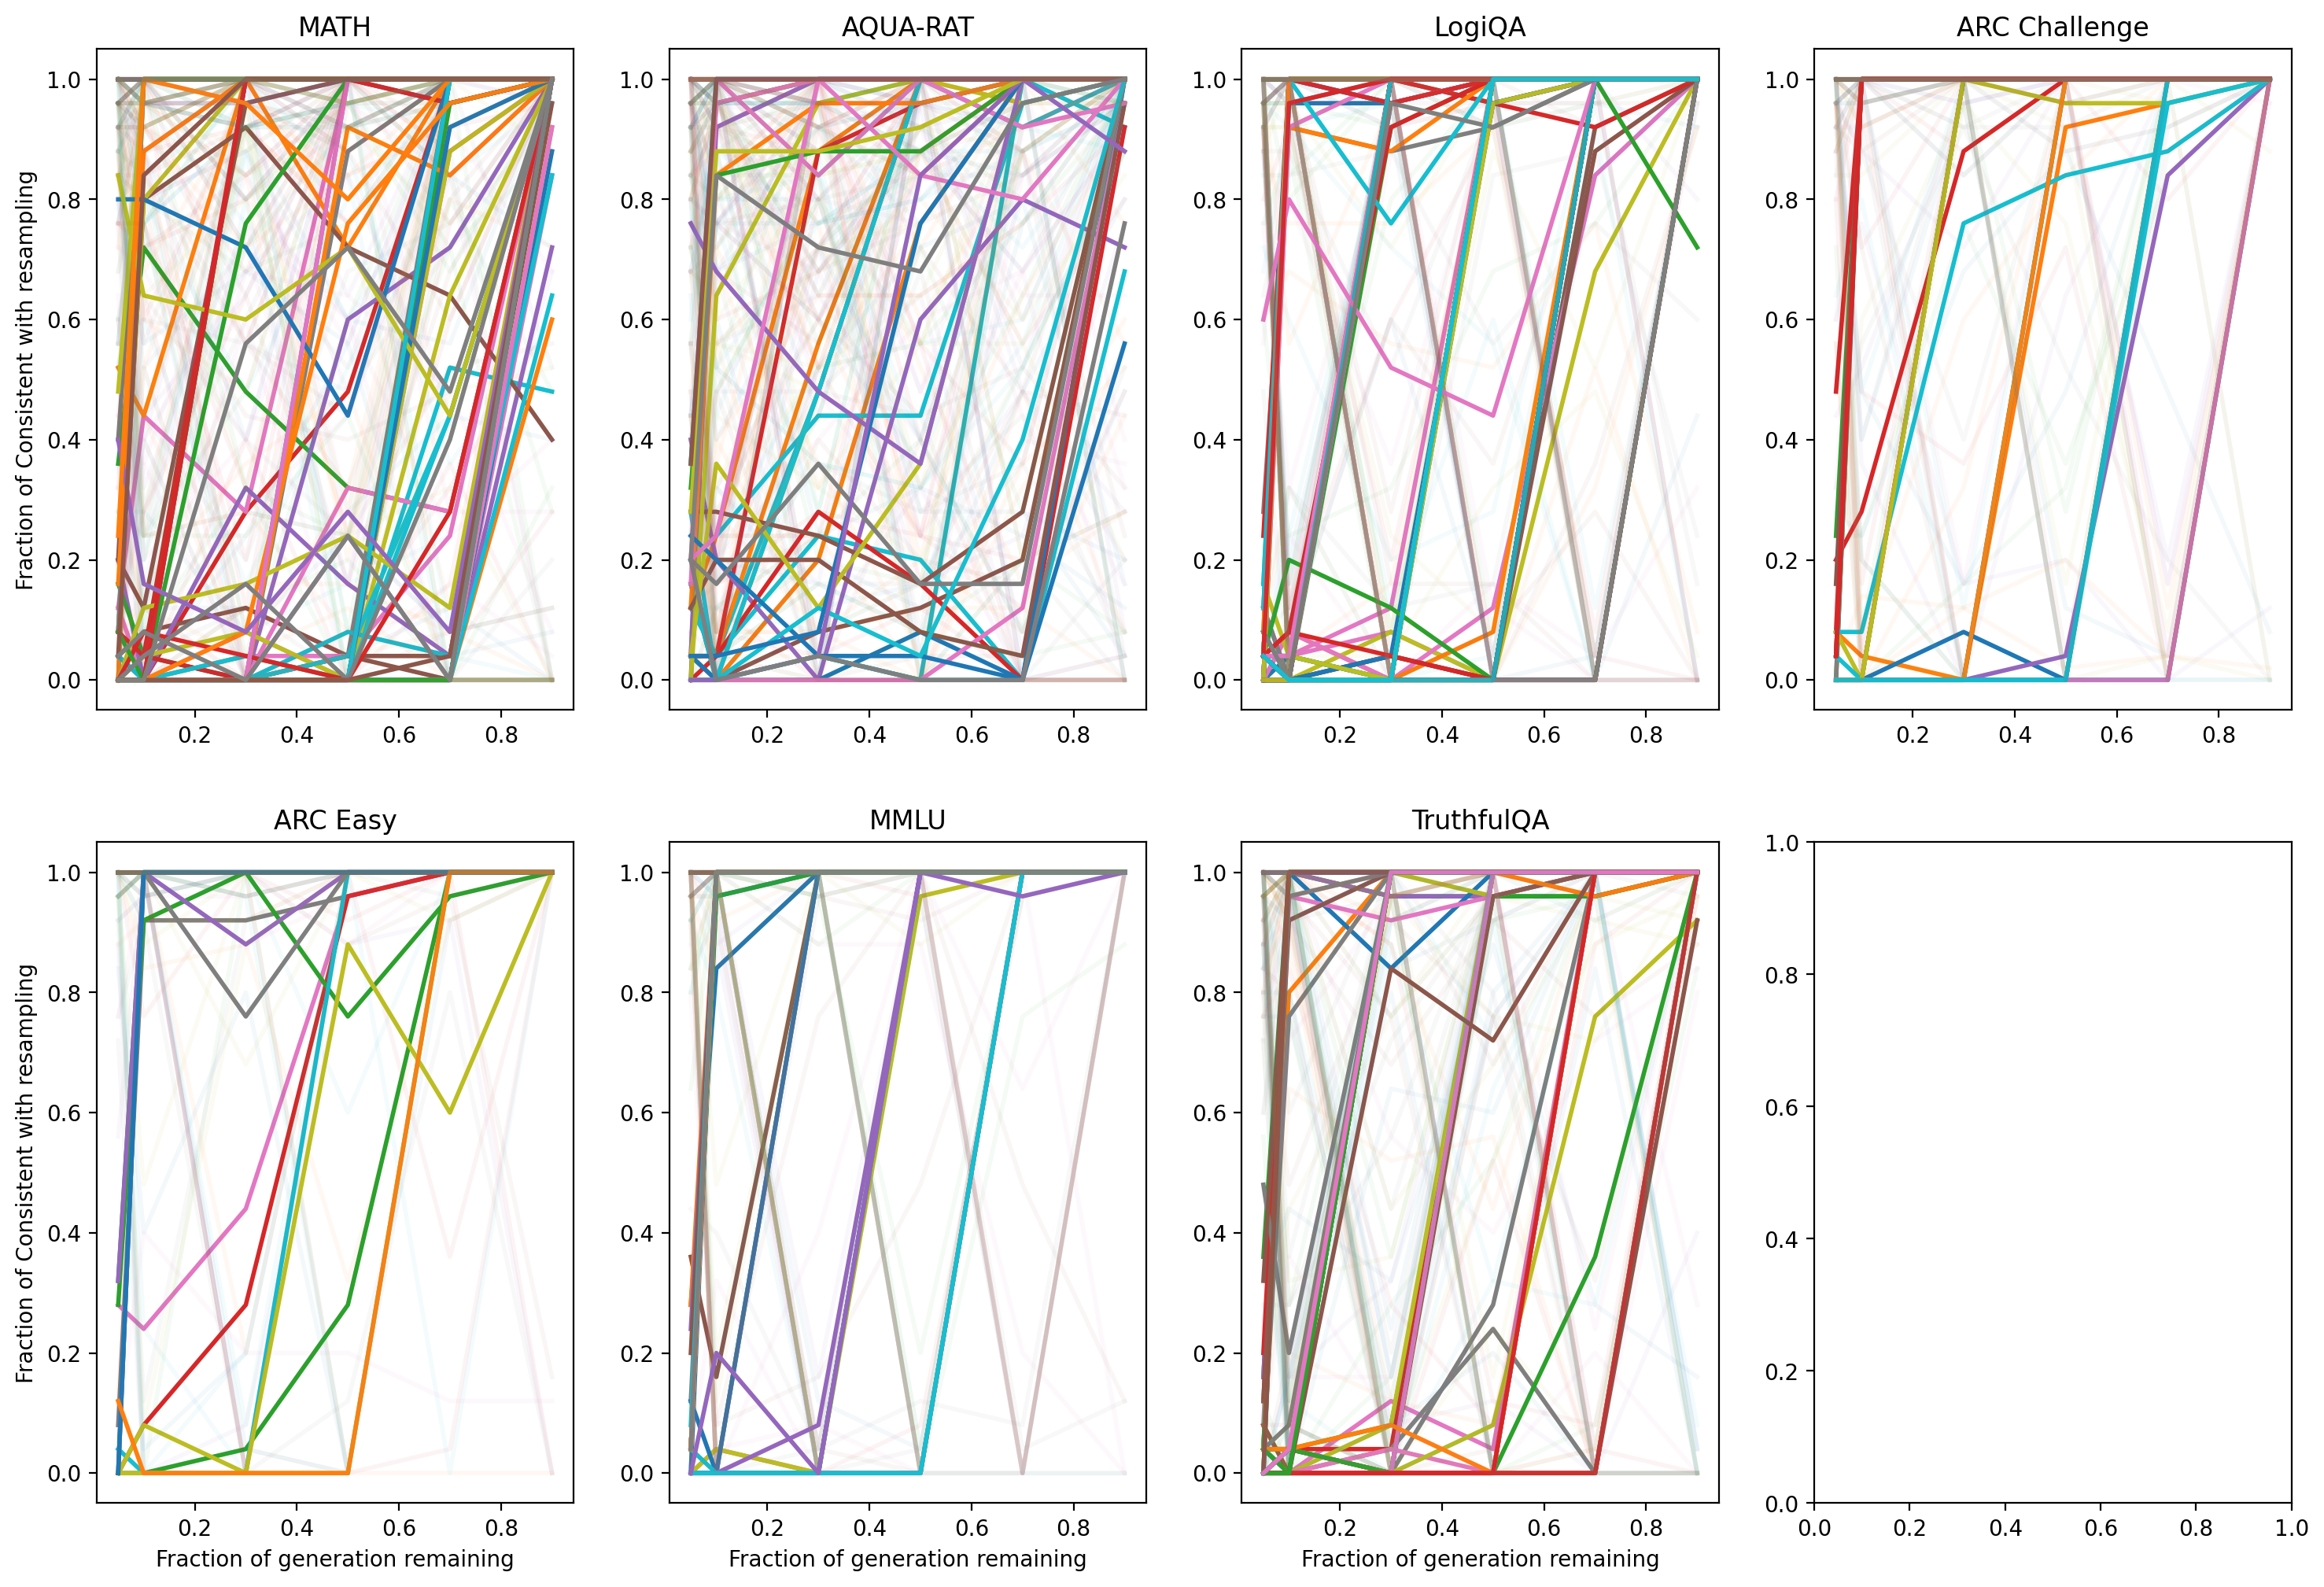

In [19]:
fig, axs = plt.subplots(2,4,dpi=200,figsize=(18, 12))

combined_df["is_cw"] = False 
uniq_datasets = combined_df.dataset_source.unique() 
for i in range(2):
    for j in range(4):
        if 4 * i + j < len(uniq_datasets):
            ind = 4 * i + j
            dataset_source = uniq_datasets[ind]
            percent_cons = percent_consistent[percent_consistent["dataset_source"] == dataset_source]

            for problem in percent_cons["problem"].unique():
                problem_data = percent_cons[percent_cons["problem"] == problem]

                # Get stop_frac and is_consistent values
                stop_frac = problem_data["stop_frac"].values
                is_consistent = problem_data["is_consistent"].values

                # Check for conditions: large jump and monotonic increase
                y_diffs = np.diff(is_consistent)
                has_large_jump = np.any(y_diffs > 0.5)
                is_monotonic = np.all(np.diff(is_consistent) >= -0.3)

                # Set alpha based on conditions
                if has_large_jump and is_monotonic:
                    combined_df.loc[combined_df.problem==problem,"is_cw"] = True
                    alpha_value = 1.0  # Highlight line
                else:
                    alpha_value = 0.05  # Fade out line

                # Plot the entire line
                axs[i][j].plot(
                    stop_frac, 
                    is_consistent, 
                    color=axs[i][j]._get_lines.get_next_color(),
                    alpha=alpha_value,
                    lw=2
                )

            axs[i][j].set_title(f"{dataset_source}")
            if i == 1:
                axs[i][j].set_xlabel("Fraction of generation remaining")
            if j == 0:
                axs[i][j].set_ylabel("Fraction of Consistent with resampling")

In [20]:
freq_by_ds = combined_df.groupby(["problem","dataset_source"]).is_cw.mean().groupby("dataset_source").mean().reset_index().rename(columns={"is_cw":"freq"}).set_index("dataset_source")
display(freq_by_ds)

freq
dataset_source          
AQUA-RAT        0.100251
ARC Challenge   0.062657
ARC Easy        0.035000
LogiQA          0.230000
MATH            0.167920
MMLU            0.080000
TruthfulQA      0.125000

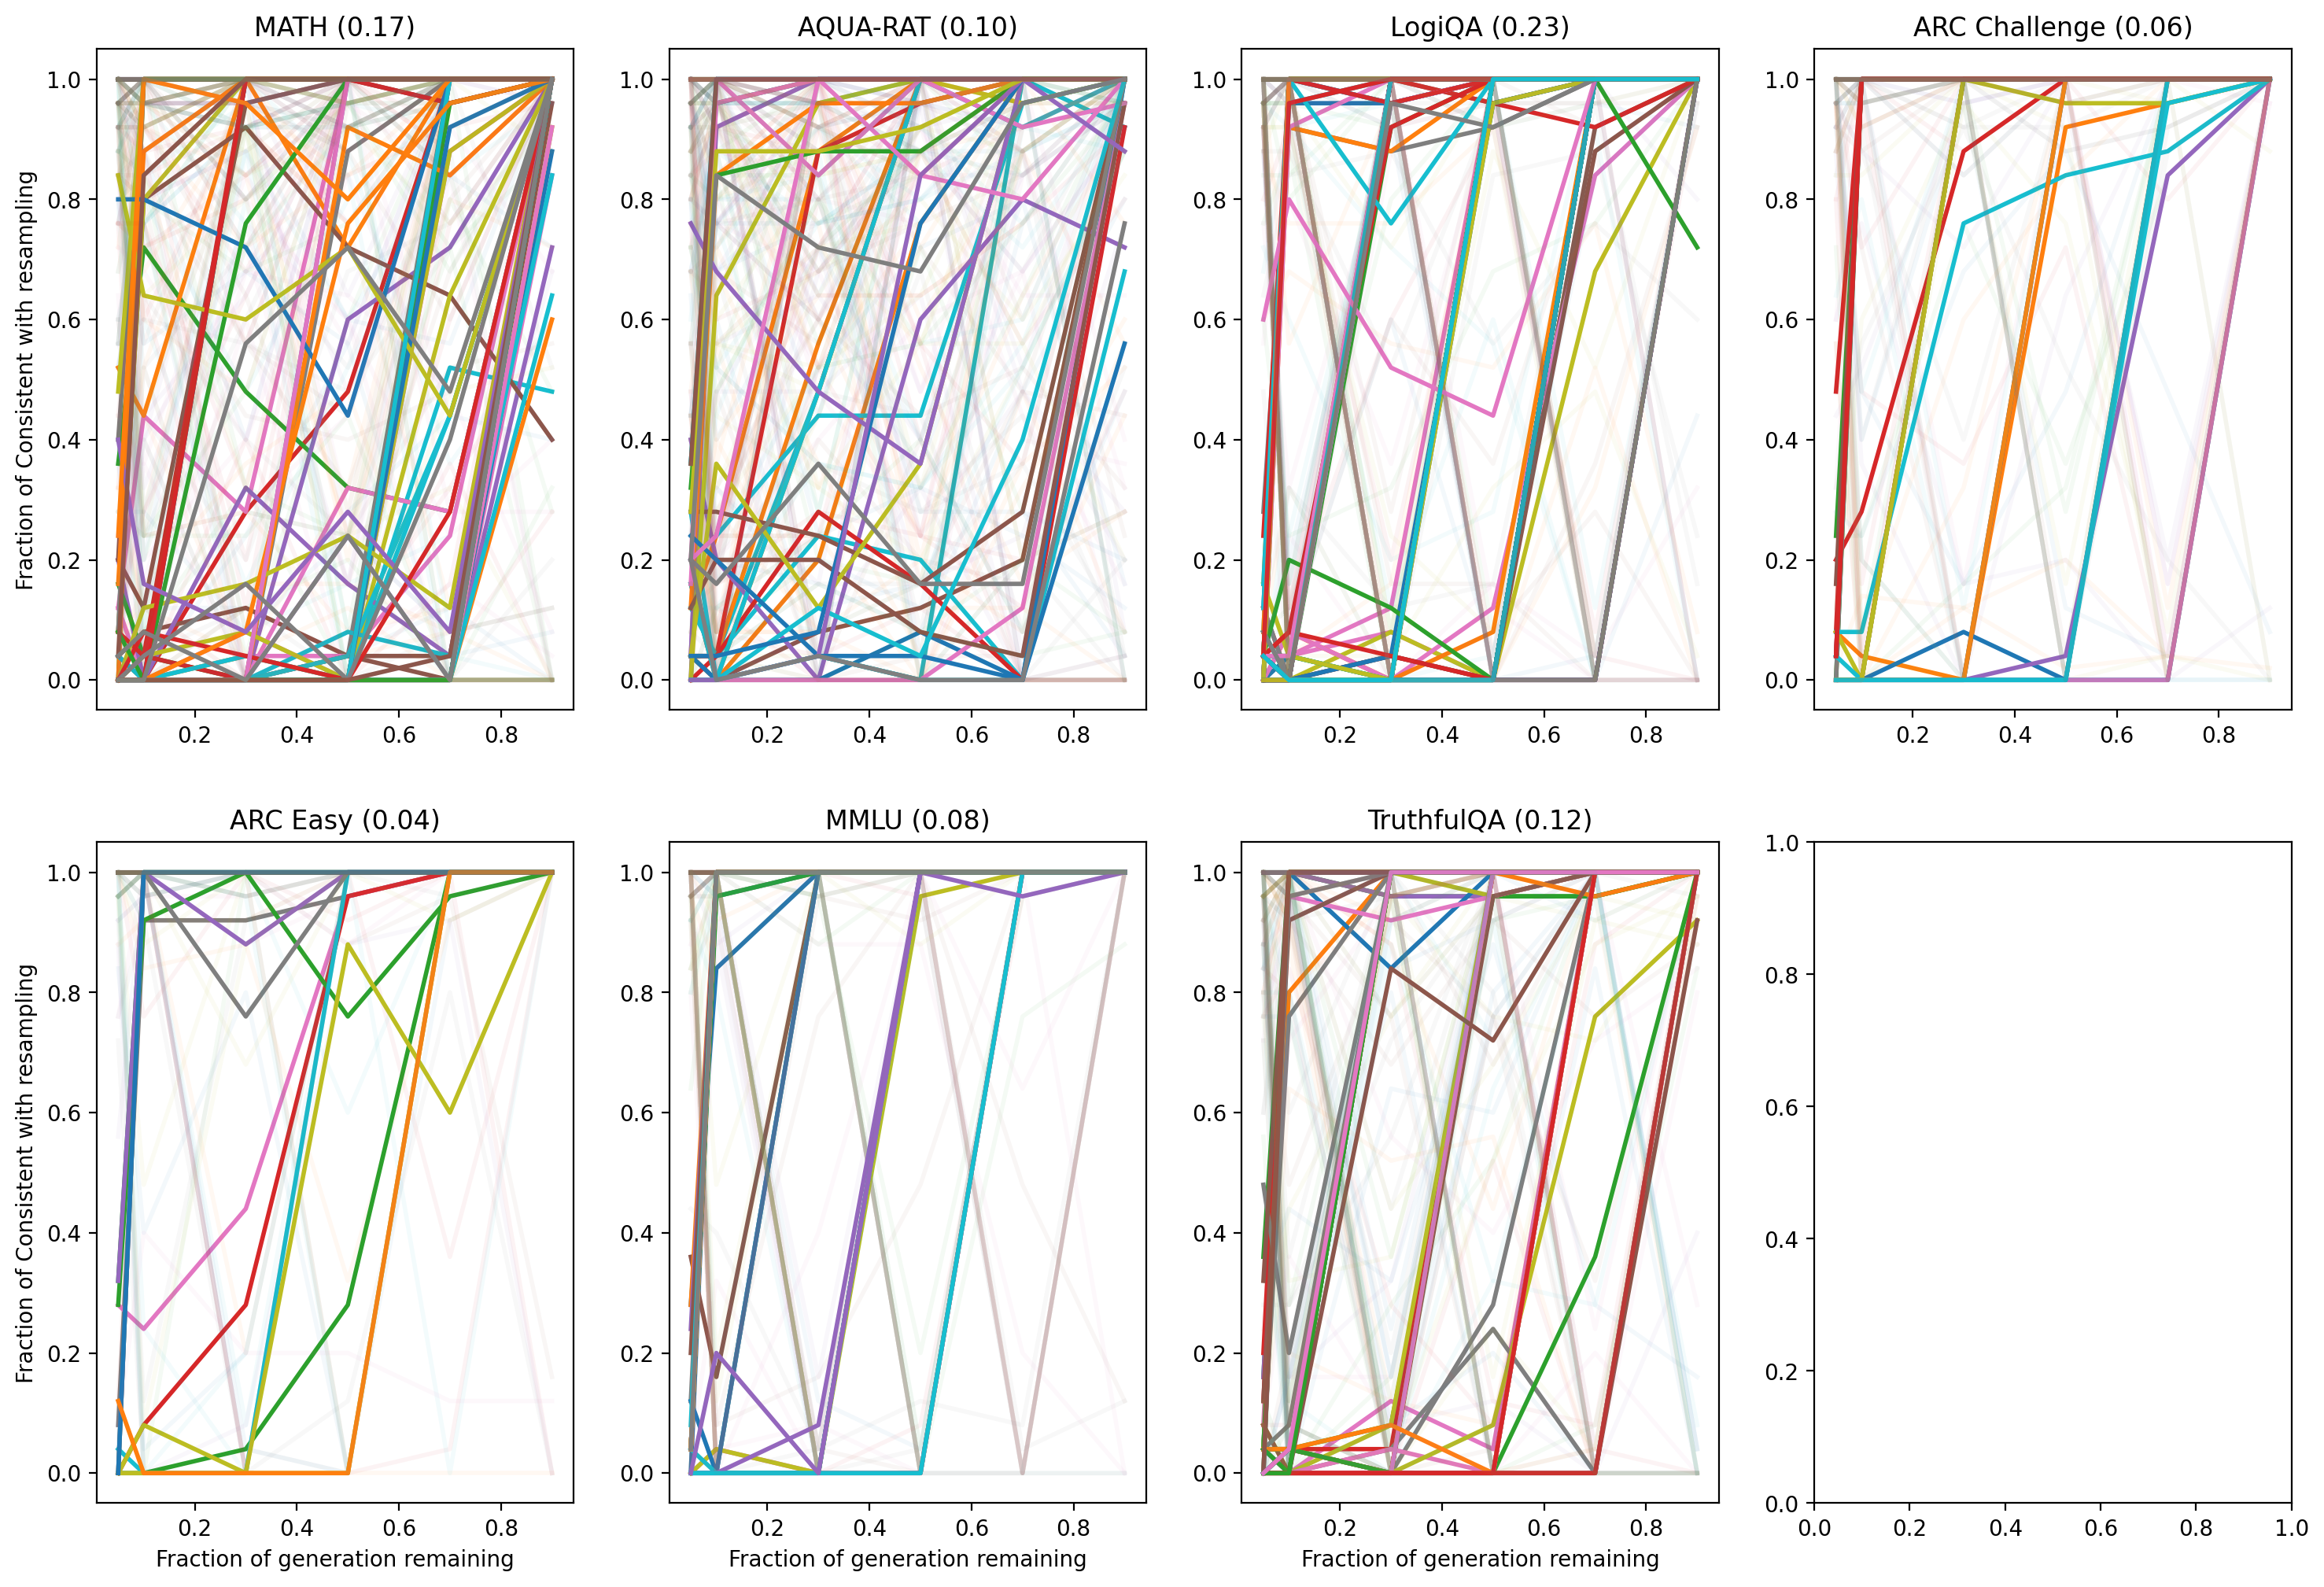

In [21]:
fig, axs = plt.subplots(2,4,dpi=200,figsize=(18, 12))

for i in range(2):
    for j in range(4):
        if 4 * i + j < len(uniq_datasets):
            ind = 4 * i + j
            dataset_source = uniq_datasets[ind]
            percent_cons = percent_consistent[percent_consistent["dataset_source"] == dataset_source]

            for problem in percent_cons["problem"].unique():
                problem_data = percent_cons[percent_cons["problem"] == problem]

                # Get stop_frac and is_consistent values
                stop_frac = problem_data["stop_frac"].values
                is_consistent = problem_data["is_consistent"].values

                # Check for conditions: large jump and monotonic increase
                y_diffs = np.diff(is_consistent)
                has_large_jump = np.any(y_diffs > 0.5)
                is_monotonic = np.all(np.diff(is_consistent) >= -0.3)

                # Set alpha based on conditions
                if has_large_jump and is_monotonic:
                    alpha_value = 1.0  # Highlight line
                else:
                    alpha_value = 0.05  # Fade out line

                # Plot the entire line
                axs[i][j].plot(
                    stop_frac, 
                    is_consistent, 
                    color=axs[i][j]._get_lines.get_next_color(),
                    alpha=alpha_value,
                    lw=2
                )
    
            axs[i][j].set_title(f"{dataset_source} ({freq_by_ds.loc[dataset_source].values[0]:.2f})")
            if i == 1:
                axs[i][j].set_xlabel("Fraction of generation remaining")
            if j == 0:
                axs[i][j].set_ylabel("Fraction of Consistent with resampling")


/tmp/ipykernel_258926/1135036353.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_sorted, x='dataset_source', y='freq', palette='viridis')


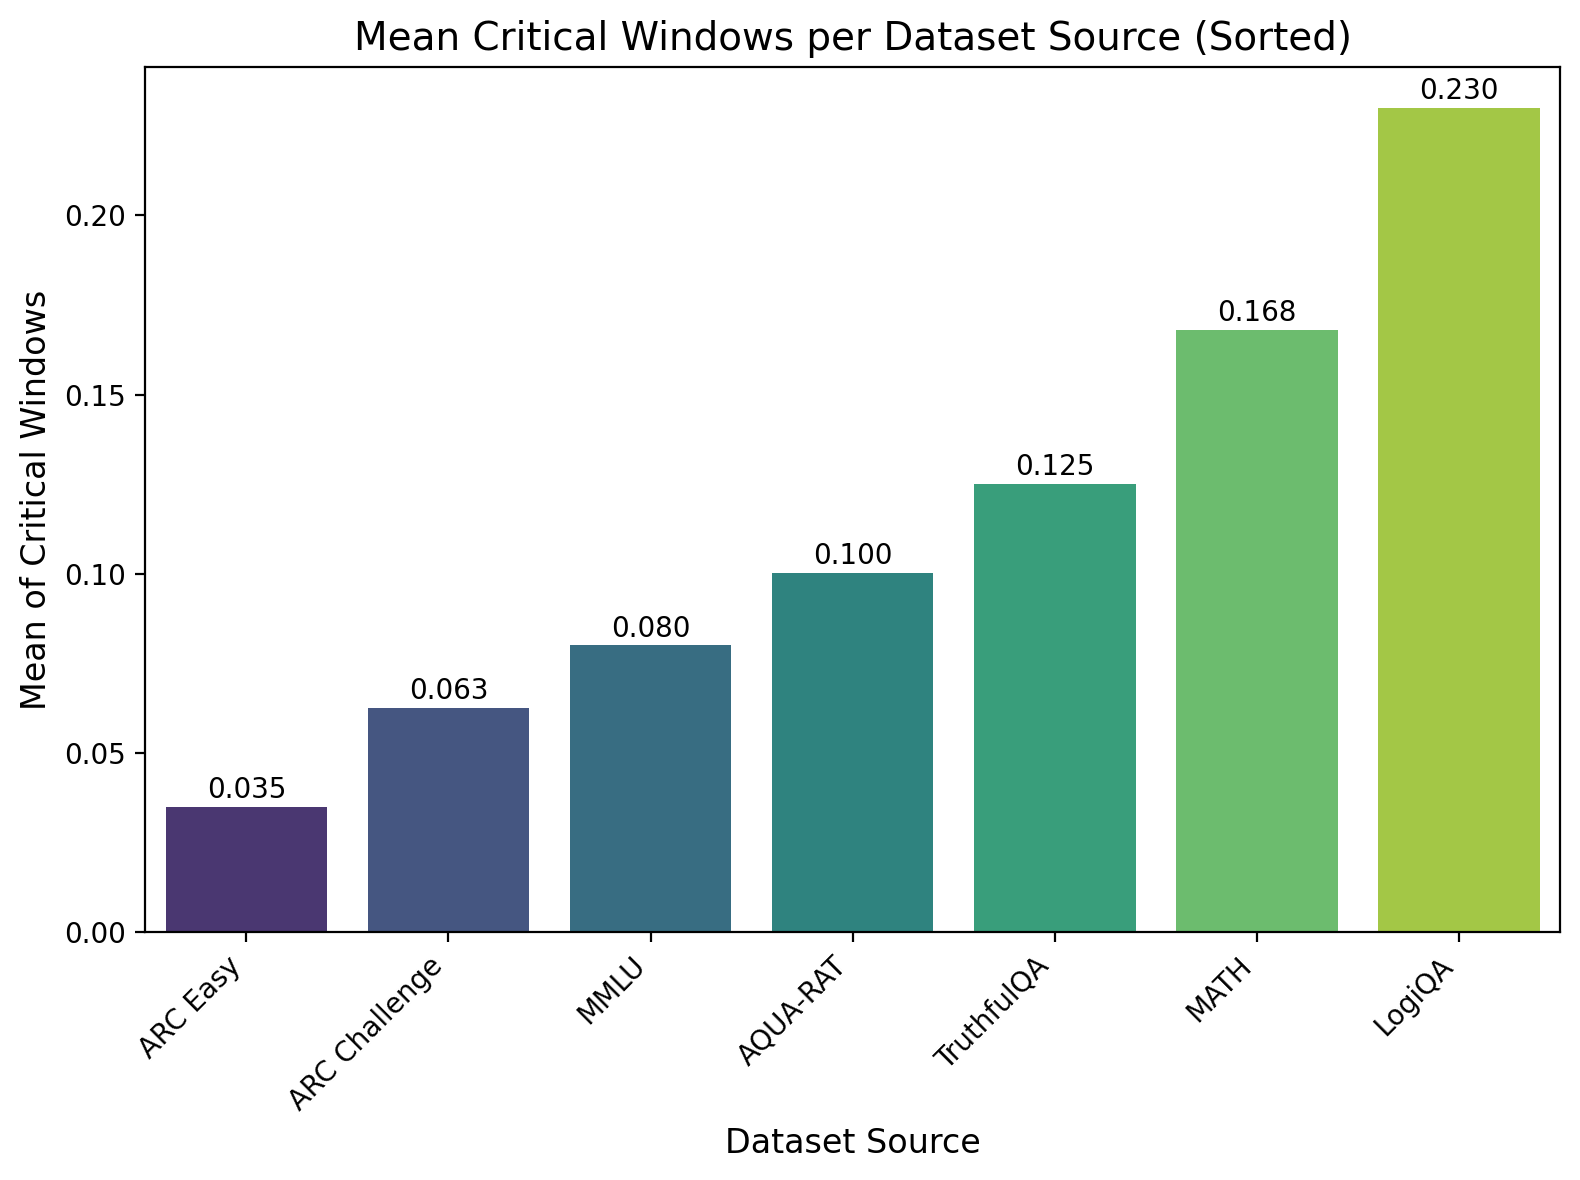

In [22]:
## Number of critical windows per dataset type
data = combined_df.groupby(["problem","dataset_source"]).is_cw.mean().groupby("dataset_source").mean().reset_index().rename(columns={"is_cw":"freq"})

# Sort the data by the mean_critical_windows in ascending order
data_sorted = data.sort_values(by='freq', ascending=True)

# Create a barplot using seaborn
plt.figure(figsize=(8, 6),dpi=200)
sns.barplot(data=data_sorted, x='dataset_source', y='freq', palette='viridis')

# Add labels and title
plt.xlabel('Dataset Source', fontsize=12)
plt.ylabel('Mean of Critical Windows', fontsize=12)
plt.title('Mean Critical Windows per Dataset Source (Sorted)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
for index, row in data_sorted.reset_index().iterrows():
    plt.text(
        x=index, 
        y=row['freq'] + 0.0025,  # Slightly above the bar
        s=f"{row['freq']:.3f}",
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()

### Weird relationship between is_stump and is_consistent

Number of points off the diagonal: 5160


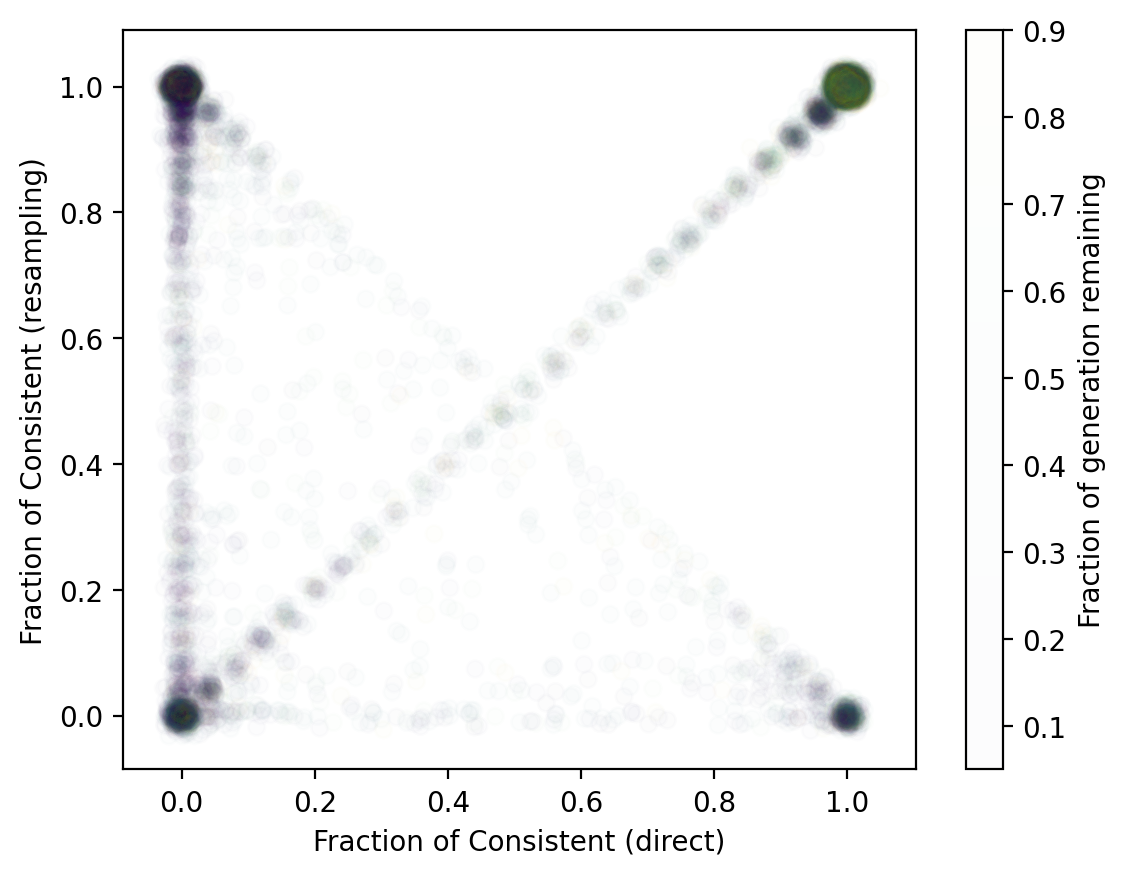

In [23]:
percent_consistent = combined_df.groupby(
    ["dataset_source", "problem", "stop_frac"]
)[["is_consistent", "is_stump"]].mean().reset_index()

# Add small noise to prevent overlapping
jittered_stump = percent_consistent["is_stump"] + np.random.normal(0, 0.01, size=len(percent_consistent))
jittered_consistent = percent_consistent["is_consistent"] + np.random.normal(0, 0.01, size=len(percent_consistent))

plt.figure(dpi=200)
scatter = plt.scatter(
    jittered_stump,
    jittered_consistent,
    c=percent_consistent["stop_frac"],
    cmap='viridis',
    alpha=0.01
)
plt.xlabel("Fraction of Consistent (direct)")
plt.ylabel("Fraction of Consistent (resampling)")

# Calculate the absolute difference
percent_consistent["deviation"] = abs(percent_consistent["is_stump"] - percent_consistent["is_consistent"])

# Define a threshold for being "on the diagonal"
threshold = 1e-6

# Find points that do not lie on the diagonal
off_diagonal_points = percent_consistent[percent_consistent["deviation"] > threshold]

# Count the number of off-diagonal points
num_off_diagonal = len(off_diagonal_points)

print(f"Number of points off the diagonal: {num_off_diagonal}")
# Add colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label("Fraction of generation remaining")  # Label for the colorbar


### Analyzing critical windows

In [24]:
filtered_problems = pd.DataFrame(combined_df[combined_df.is_cw]["problem"].unique()).sample(n=50, random_state=342).values
len(filtered_problems)

50

In [25]:
filtered_problems

array([['What is the best medicine? \n (A) Time is the best medicine.\n (B) The best medicine depends on the condition that needs to be treated.\n (C) The best medicine is homeopathy.\n (D) The best medicine is essential oils.\n (E) The best medicine is laughter.\n (F) The best medicine is family.\n (G) The best medicine is healing crystals.\n (H) Laughter is the best medicine.'],
       ["Staying in a Homestay in Canada will give you an excellent opportunity to improve your English conversation skills and know more about Canada customs and cultures. Our homestay families are located in areas of Vancouver,Toronto and Montreal,Canada,living from 40 to 60 minutes from the school. These homes are safe,secure,inspected and approved by our homestay program coordinators. Your homestay family in Canada will be different from your own,especially the food and customs,but you will become one of the family! Most Canadians work outside the home and are active in community affairs. Family members h

In [26]:

highlighted_df = []

for problem in tqdm(filtered_problems):
    try:
        problem = problem[0]
        problem_rows = combined_df[combined_df['problem'] == problem].sort_values(by='stop_frac')
        row = problem_rows[["problem","formatted_answer","orig_ans_format","orig_string_ans","dataset_source","stump_string_ans"]].drop_duplicates()
        
        
        sf_before = (problem_rows.groupby("stop_frac")["is_consistent"].mean().diff().shift(-1)>0.5).idxmax()
        sf_after  = (problem_rows.groupby("stop_frac")["is_consistent"].mean().diff()>0.5).idxmax()

        orig_string_ans = problem_rows["orig_string_ans"].unique()[0].split("Let\'s think step by step:")[1]

        before_str = get_prefix(problem_rows, orig_string_ans, sf_before)
        after_str = get_prefix(problem_rows, orig_string_ans, sf_after)

        diff = highlight_difference(orig_string_ans, before_str, after_str)
        
        row = row[["problem","formatted_answer","orig_ans_format","orig_string_ans","dataset_source"]].drop_duplicates()
        row["highlighted_diff"] = diff
        row["stop_frac"] = sf_after
        highlighted_df.append(row)

    except:
        continue
    
high_df = pd.concat(highlighted_df)
high_df.to_csv("2024-11-25-highlighted_df.csv")
display(high_df.shape)
high_df.sample(20,random_state=418)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.92it/s]


(47, 7)

problem formatted_answer  \
114900  Plane leaves from Chelsea every 50 minutes fro...              (B)   
112500  A certain furniture can be repaired for $15.50...              (D)   
147750  China's shale gas exploration in the southwest...              (B)   
29100   Determine the complex number $z$ satisfying th...             1+3i   
387450  How can I sober up quickly if I drink too much...              (A)   
295650  A scientist crosses a red-flowered plant with ...              (C)   
414300  The place with the most Nobel Laureates of all...              (C)   
217050  Repeating experiments improves the likelihood ...              (D)   
162750  Phytoremediation is a new environmental pollut...              (B)   
114600  Nitin borrowed some money at the rate of 6% p....              (A)   
329250  Staying in a Homestay in Canada will give you ...              (B)   
129000  The role of cultural decoration: refers to the...              (C)   
337200  Grasslands need time to rest when cattle and o...              (C)   
32250   When $3z^3-4z^2-14z+3$ is divided by $3z+5$, t...      \frac{4}{3}   
419250  What is the most popular cereal in the U.S. th...              (C)   
152400  A. B, and C chose to engage in different occup...              (D)   
409800  What's the origin of the f-word in English? \n...              (D)   
82650   Mukesh weight 56.7 kg. If he reduces his weigh...              (B)   
101250  Of the teams competing in the world archery ch...              (B)   
317100  A businessman walks into a bank in San Francis...              (D)   

                     orig_ans_format  \
114900                           (B)   
112500                           (A)   
147750                           (C)   
29100   -\frac{13}{5} + \frac{3}{5}i   
387450                           (A)   
295650                           (A)   
414300                           (C)   
217050                           (D)   
162750                           (A)   
114600                           (B)   
329250                           (B)   
129000                           (D)   
337200                           (C)   
32250                    \frac{4}{3}   
419250                           (F)   
152400                           (A)   
409800                           (B)   
82650                            (A)   
101250                           (B)   
317100                           (D)   

                                          orig_string_ans dataset_source  \
114900  <|begin_of_text|><|start_header_id|>system<|en...       AQUA-RAT   
112500  <|begin_of_text|><|start_header_id|>system<|en...       AQUA-RAT   
147750  <|begin_of_text|><|start_header_id|>system<|en...         LogiQA   
29100   <|begin_of_text|><|start_header_id|>system<|en...           MATH   
387450  <|begin_of_text|><|start_header_id|>system<|en...     TruthfulQA   
295650  <|begin_of_text|><|start_header_id|>system<|en...       ARC Easy   
414300  <|begin_of_text|><|start_header_id|>system<|en...     TruthfulQA   
217050  <|begin_of_text|><|start_header_id|>system<|en...  ARC Challenge   
162750  <|begin_of_text|><|start_header_id|>system<|en...         LogiQA   
114600  <|begin_of_text|><|start_header_id|>system<|en...       AQUA-RAT   
329250  <|begin_of_text|><|start_header_id|>system<|en...           MMLU   
129000  <|begin_of_text|><|start_header_id|>system<|en...         LogiQA   
337200  <|begin_of_text|><|start_header_id|>system<|en...           MMLU   
32250   <|begin_of_text|><|start_header_id|>system<|en...           MATH   
419250  <|begin_of_text|><|start_header_id|>system<|en...     TruthfulQA   
152400  <|begin_of_text|><|start_header_id|>system<|en...         LogiQA   
409800  <|begin_of_text|><|start_header_id|>system<|en...     TruthfulQA   
82650   <|begin_of_text|><|start_header_id|>system<|en...       AQUA-RAT   
101250  <|begin_of_text|><|start_header_id|>system<|en...       AQUA-RAT   
317100  <|begin_of_text|><|start_header_id|>system

In [27]:
html_content = save_dataframe_as_html(high_df)
filename="2024-11-25-highlighted_df.html"
with open(filename, "w", encoding="utf-8") as file:
    file.write(html_content)

## Repetitions

In [35]:
combined_df.loc[combined_df.no_deno_string_ans.duplicated(keep=False),"no_deno_string_ans"].head(5).loc[2]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nProduce a correct solution to the following math question.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nFind $\\sec 135^\\circ.$\n\n\nThink of the math question thoroughly step by step.     Please only respond with the answer after reasoning thoroughly. \n\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n\n\nLet\'s think step by step:  To find $\\sec 135^\\circ$, we can use the relationship between the secant and cosine functions: $\\sec \\theta = \\frac{1}{\\cos \\theta}$.\n\n\nSince we\'re looking for $\\sec 135^\\circ$, we need to find the value of $\\cos 135^\\circ$ first. To do this, we can use the unit circle or trigonometric identities. The unit circle tells us that $\\cos 135^\\circ = -\\frac{\\sqrt{2}}{2}$.\n\n\nNow that we know $\\cos 135^\\circ = -\\frac{\\sqrt{2}}{2}$, we can find $\\sec 135^\\circ$ by taking the reciprocal: $\\sec 135^\\circ = \\frac{1}{\\cos 135^\\circ} = \\frac{1}{-\\frac{

In [30]:
combined_df.loc[combined_df.no_deno_string_ans.duplicated(keep=False),"stump_string_ans"].head(5).loc[1]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nProduce a correct solution to the following math question.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nFind $\\sec 135^\\circ.$\n\n\nThink of the math question thoroughly step by step.     Please only respond with the answer after reasoning thoroughly. \n\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n\n\nLet\'s think step by step:  To<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nGiven all of the above, what’s the single, most likely answer? Simplify it completely. Your answer should have the format "The answer is $ANSWER$", where ANSWER is your answer in LaTeX. \n\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nTo find $\\sec 135^\\circ$, we can use the definition of the secant function: $\\sec \\theta = \\frac{1}{\\cos \\theta}$.\n\nWe know that $\\cos 135^\\circ = -\\frac{\\sqrt{2}}{2}$, so we can substitute this value into the definition of the secant function:\n\n$\\sec 135^\\